# Project 1: Exploratory Data Analysis of Movies
Amelia Dahm & Khyatee Desai

## Import Python Libraries

In [200]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from bs4 import BeautifulSoup
%matplotlib inline

## Read in CSV Files

In [201]:
movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')

# Question 1: Which Movies Genres are Most Successful?


##  Read in Oscars Dataset
Source: https://www.kaggle.com/unanimad/the-oscar-award

In [202]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw.head(3)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False


## Get the count of Oscar Nominations per movie

In [203]:
# subset the relevant data from Oscars df. Rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)
oscars.head(3)

,title,person,category,oscar_noms
0,The Noose,Richard Barthelmess,ACTOR,1
1,The Last Command,Emil Jannings,ACTOR,2
2,A Ship Comes In,Louise Dresser,ACTRESS,1


## Unstack the Genre values
Genres were originally formatted as a comma-delimited string (ie 'Action, Crime, Drama'.) We reformatted this to give each genre its own row in the table.

In [204]:
# Unstacking Genre column to create individual rows (takes a while to run cell)
genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('primary_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['primary_title', 'genres']
genre_unstack.head(3)

,primary_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama


## Merge Oscars table with Genre table

In [205]:
oscar_genre = oscars.merge(genre_unstack, how = 'left', left_on='title', right_on='primary_title').drop('primary_title', axis=1)
oscar_genre.head(3)

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN


## Clean Gross Revenue Table

In [206]:
# subset relevant data, change strings to floats
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','').astype(float)
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross
movie_gross.head(3)

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08


 ## Clean Budgets Table

In [207]:
# subset relevant data, change strings to floats
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'total_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['total_gross'] = budgets['total_gross'].str.replace('$','')
budgets['total_gross'] = budgets['total_gross'].str.replace(',','').astype(float)
budgets.head(3)

,title,production_budget,domestic_gross,total_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08


## Concatenate Gross Revenue Table with Budgets Table

In [208]:
# concat gross and budget tables, create columns for total_gross and Return on Investment, drop duplicate rows
budget_concat = pd.concat([movie_gross, budgets], sort=True)
budget_concat['roi'] = (((budget_concat.total_gross - budget_concat.production_budget)/budget_concat.production_budget)* 100).round(2)
budget_concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
budget_concat.sample(3)

,domestic_gross,foreign_gross,production_budget,title,total_gross,roi
4163,3273588.0,NaN,6000000.0,Only the Strong,3273588.0,-45.44
5462,6840.0,NaN,500000.0,Scott Walker: 30 Century Man,77121.0,-84.58
2565,30113491.0,NaN,20000000.0,Ghost Ship,68349884.0,241.75


# Final Oscar Nominations, Genre, and Budget DataFrame

In [209]:
# subset the oscars table, drop duplicate listings
oscar_df = oscar_genre.loc[:,['title', "oscar_noms", 'genres']]
oscar_df.drop_duplicates(inplace=True)

# merged genre/oscar table with budgets (used Left Join to retain all Oscar data)
oscar_df = oscar_df.merge(budget_concat[['title','production_budget', "total_gross", 'roi']], on='title', how='left').set_index('title')
oscar_df.sort_values('oscar_noms', ascending=False)

,oscar_noms,genres,production_budget,total_gross,roi
title,,,,,
A Star Is Born,25,Romance,NaN,NaN,NaN
A Star Is Born,25,Drama,NaN,NaN,NaN
A Star Is Born,25,Music,NaN,NaN,NaN
Titanic,16,Family,200000000.0,2.208208e+09,1004.10
Titanic,16,Adventure,200000000.0,2.208208e+09,1004.10
...,...,...,...,...,...
Evolution,1,Mystery,80000000.0,9.834193e+07,22.93
Evolution,1,Drama,80000000.0,9.834193e+07,22.93
The Crunch Bird,1,NaN,NaN,NaN,NaN


# Question 1 Analysis 

## Oscar Nominations vs Total Gross Revenue
Dropped 3 outliers with highest Total Gross Revenue (Avatar, Titanic, and Avengers: Infinity War)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


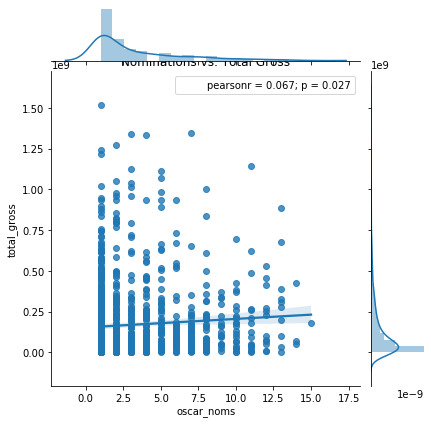

In [210]:
from scipy.stats import pearsonr

x ='oscar_noms'
y = 'total_gross'


# drop duplicates that exist because of genre unstacking (genre not relevant for this chart)
noms_vs_budget = oscar_df.loc[:,[x, y]].drop_duplicates().sort_values(y).dropna()[:-3] # exclude outliers
sns.jointplot(x,y, data = noms_vs_budget, stat_func=pearsonr, kind='reg');
plt.title('Nominations vs. Total Gross');


## Oscar Nominations and Total Gross Revenue, By Genre

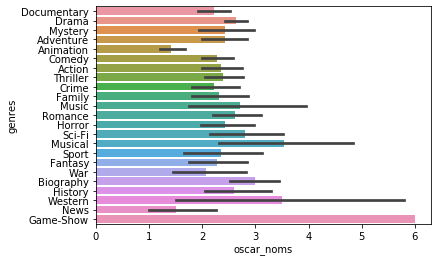

In [211]:
sns.barplot('oscar_noms','genres' , data = oscar_df);

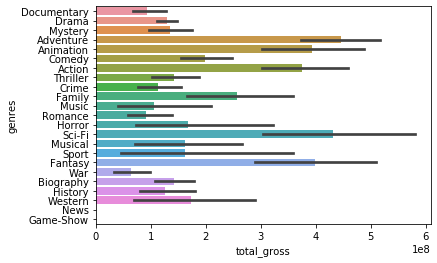

In [212]:
sns.barplot('total_gross','genres' , data = oscar_df);

# Question 2: How does Trailer Popularity impact Movie Success?
### Task: Compare movie trailer view counts to movie ratings and revenue

### Data of Interest:
- trailer views
- gross revenue
- online ratings

### Datasets:
https://grouplens.org/datasets/movielens/20m-youtube/

In [213]:
# slice year out of title string, merge with budgets table
trailers_raw = pd.read_csv('./zippedData/movie_trailers.zip')
trailers_raw['title'] = trailers_raw['title'].str[:-7]
trailers = trailers_raw.merge(budget_concat, on='title').sort_values('total_gross', ascending=False) #### remove this later
ids = list(trailers["youtubeId"].values[:])
trailers

,youtubeId,movieId,title,domestic_gross,foreign_gross,production_budget,total_gross,roi
2745,5MB3Ea6L-gw,72998,Avatar,760507625.0,NaN,425000000.0,2.776345e+09,553.26
458,dQ7MAigAhas,3404,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
457,2e-eXJ6HgkQ,1721,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
459,yxIVO7P0iig,118916,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
2798,tck0UR2ppjg,82452,Frozen,400738009.0,NaN,150000000.0,1.272470e+09,748.31
...,...,...,...,...,...,...,...,...
4012,myjar5KoqZA,129820,Spare Parts,3600000.0,NaN,NaN,NaN,NaN
4017,utmvmr7cgcg,130052,Clown,55000.0,NaN,NaN,NaN,NaN
4020,tRn3gr8Pt_o,130382,Mr. Pip,1700.0,NaN,NaN,NaN,NaN
4028,6uaWekLrilY,131023,That Sugar Film,3500.0,NaN,NaN,NaN,NaN


## Create function to feed in youtube id's of trailers and retrieve view counts

In [ ]:
def getViews(youtubeIDs):
    views = []
    for i in youtubeIDs:
        try:
            url = "https://www.youtube.com/watch?v={}".format(i)
            html_page = requests.get(url) 
            soup = BeautifulSoup(html_page.text, 'html.parser')
            script = soup.find_all('script')[32]
            value = re.findall('ewCount":{"simpleText":"([\d,]+) views', str(soup))
            views.append(float(value[0].replace(',','')))
        except:
            views.append(0)
    return views


## Scrape all YouTube Trailers and save as CSV (Warning: takes ~1hr to run)
### Leave this commented out

In [215]:
# trailers['trailer_views'] = getViews(ids)
# trailers.to_csv('zippedData/trailerViews.csv')

# Final Trailer Views vs ROI DataFrame

In [216]:
# sort by trailer views and drop duplicates to keep only trailer with highest views
trailer_df = pd.read_csv('zippedData/trailerViews.csv')
trailer_df = trailer_df.loc[:,['title','youtubeId','production_budget', 'total_gross', 'roi', 'trailer_views']].sort_values('trailer_views', ascending=False)
trailer_df = trailer_df.drop_duplicates(subset= ['title'], keep='first').set_index('title')
trailer_df

,youtubeId,production_budget,total_gross,roi,trailer_views
title,,,,,
Unfaithful,j-V12tL78Mc,50000000.0,1.191145e+08,138.23,117290789.0
Ilo Ilo,ISovsVvX8Bg,NaN,1.156800e+06,NaN,67247941.0
Transformers: Dark of the Moon,3H8bnKdf654,195000000.0,1.123791e+09,476.30,53112332.0
The Fault in Our Stars,9ItBvH5J6ss,12000000.0,3.071668e+08,2459.72,44956623.0
Eden,pdbI0Fn4COQ,2300000.0,0.000000e+00,-100.00,43188495.0
...,...,...,...,...,...
Harry Brown,I2S3SraFmI0,7300000.0,1.202361e+07,64.71,0.0
Elles,YIWiNzszcAo,NaN,9.120000e+05,NaN,0.0
Miral,4t8E6_S9f4k,NaN,9.000000e+05,NaN,0.0


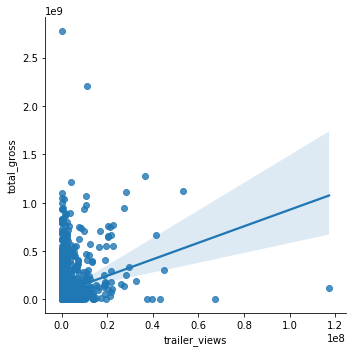

In [217]:
sns.lmplot('trailer_views', 'total_gross', data = trailer_df)

# Question 3: Do Music Scores Contribute to Movie Success?
### Task: Look at how music score ratings compare to movie ratings and ROI
### Data of Interest:
- Composers
- Music Score Rating
- Average Movie Rating
- TMDB rating
- IMDB rating
- ROI

### Datasets: 
- https://www.soundtrack.net/content/reviews/ (not sure if we will end up using this one)
- http://www.movie-wave.net/reviews-by-composer/


## Scrape music reviews page

In [218]:
page = requests.get("http://www.movie-wave.net/reviews-by-title/")
soup = BeautifulSoup(page.content, 'html.parser')
content =soup.find('div', class_="page-content")
p_list = content.findAll('p')

In [219]:
to_df =[]
for p in p_list:
    for a in p.findAll('a'):
        try:
           to_df.append([a.text, a.nextSibling, a.nextSibling.nextSibling.text])
        except:
            pass


## Create DataFrame with Music Ratings

In [220]:
music_df = pd.DataFrame(to_df, columns=['title', 'composer', 'stars'])
music_df['composer'] = music_df['composer'].str[:-7]

In [221]:
stars = list(music_df['stars'])
mapper = {'*****':5, '**** 1/2':4.5,'****':4,'*** 1/2':3.5,'***':3,'** 1/2':2.5,'**':2,'* 1/2':1.5,'*':1}
ratings = list(map(mapper.get, stars))
music_df['music_rating'] = ratings
music_df = music_df.drop('stars',axis=1)
music_df

,title,composer,music_rating
0,10 Cloverfield Lane,Bear McCreary,4.0
1,100 Rifles,Jerry Goldsmith,4.0
2,101 Dalmatians,Michael Kamen,4.5
3,102 Dalmatians,David Newman,4.0
4,"10,000BC",Harald Kloser and Thomas Wander,2.0
...,...,...,...
2294,Zathura,John Debney,4.0
2295,Zero Dark Thirty,Alexandre Desplat,4.0
2296,Zoolander 2,Theodore Shapiro,3.5
2297,Zootopia,Michael Giacchino,2.0


## Merge TMDB Ratings with Budget/ROI table


In [222]:
# Rename columns to specify TMDB, and subset data to only get columns of interest
tmdb = tmdb_raw.merge(budget_concat[['title', 'total_gross','production_budget', 'roi']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb = tmdb.loc[:,['title', 'tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi']]
tmdb.head()

,title,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,33.533,NaN,NaN,NaN
1,How to Train Your Dragon,7.7,7610,28.734,494870992.0,165000000.0,199.92
2,Iron Man 2,6.8,12368,28.515,621156389.0,170000000.0,265.39
3,Toy Story,7.9,10174,28.005,364545516.0,30000000.0,1115.15
4,Inception,8.3,22186,27.920,835524642.0,160000000.0,422.20


## merge in IMDB ratings with above TMDB table

In [223]:
# To retain as much info as possible, joined imdb_ratings with title table rather than title_basics
imdb = imdb_raw.merge(titles_raw,left_on ='tconst', right_on ='title_id')
imdb.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)
imdb = imdb[['title', 'imdb_rating', 'imdb_votes' ]]
ratings = imdb.merge(tmdb, on='title', how='left')
ratings.head()

,title,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
1,Samo Ines,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
2,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
3,The Legend of Hercules,4.2,50352,4.5,805.0,13.754,58953319.0,70000000.0,-15.78
4,Hércules - A Lenda Começa,4.2,50352,NaN,NaN,NaN,NaN,NaN,NaN


# Final Music X IMDB X TMDB X Revenue Table

In [224]:
final_music = music_df.merge(ratings, on='title', how='inner')

In [226]:
final_music.isnull().sum()

title                   0
composer                0
music_rating           84
imdb_rating             0
imdb_votes              0
tmdb_rating           558
tmdb_votes            558
tmdb_popularity       558
total_gross          1193
production_budget    1401
roi                  1401
dtype: int64

In [227]:
music_imdb = final_music.drop(['tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi'], axis=1)
music_imdb.dropna(inplace=True)

In [231]:
music_imdb = music_imdb.sort_values('imdb_rating').dropna()[:-5]

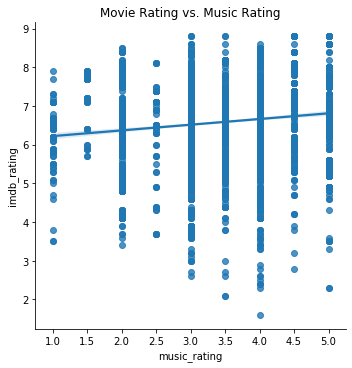

In [232]:
# remove  bottom 5 imdb_outliers
music_imdb = music_imdb.sort_values('imdb_rating').dropna()[:-5]
sns.lmplot('music_rating','imdb_rating',  data = music_imdb);
plt.title('Movie Rating vs. Music Rating');

#### There is a positivve correlation between music ratings and the imdb movie rating. 

### Clean Movie Budget DataFrame and Compute ROI

In [233]:
gross = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
gross['year'] = gross['release_date'].str[-4:].astype(float)
gross['domestic_gross'] = gross['domestic_gross'].str.replace(',', '')
gross['domestic_gross'] = gross['domestic_gross'].str.replace('$', '').astype(float)
gross['production_budget'] = gross['production_budget'].str.replace(',', '')
gross['production_budget'] = gross['production_budget'].str.replace('$', '').astype(float)
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace(',', '')
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace('$', '').astype(float)

In [234]:
gross['ROI'] = (((gross['worldwide_gross'] - gross['production_budget']) / gross['production_budget'] ) * 100)

In [235]:
# renaming and setting index for merging purposes
gross.rename(columns = {'movie': 'original_title'}, inplace=True)
gross.set_index('original_title')

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,ROI
original_title,,,,,,,
Avatar,1,"Dec 18, 2009",425000000.0,760507625.0,2.776345e+09,2009.0,553.257713
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000.0,241063875.0,1.045664e+09,2011.0,154.667286
Dark Phoenix,3,"Jun 7, 2019",350000000.0,42762350.0,1.497624e+08,2019.0,-57.210757
Avengers: Age of Ultron,4,"May 1, 2015",330600000.0,459005868.0,1.403014e+09,2015.0,324.384139
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000.0,620181382.0,1.316722e+09,2017.0,315.369636
...,...,...,...,...,...,...,...
Red 11,78,"Dec 31, 2018",7000.0,0.0,0.000000e+00,2018.0,-100.000000
Following,79,"Apr 2, 1999",6000.0,48482.0,2.404950e+05,1999.0,3908.250000
Return to the Land of Wonders,80,"Jul 13, 2005",5000.0,1338.0,1.338000e+03,2005.0,-73.240000


### Stack Genre DataFrame and Merge with Financial Data

In [263]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw

genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('original_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['original_title', 'genres']

In [264]:
genre_unstack

,original_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama
3,Ashad Ka Ek Din,Biography
4,Ashad Ka Ek Din,Drama
...,...,...
229545,The Secret of China,War
229546,Kuambil Lagi Hatiku,Drama
229547,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
229548,Dankyavar Danka,Comedy


In [265]:
# Merge with budget table and remove null values
genre_roi = genre_unstack.merge(gross[['original_title', 'ROI']], on='original_title', how='left')
genre_roi.dropna(axis = 0, inplace = True)

In [266]:
genre_roi

,original_title,genres,ROI
32,Foodfight!,Action,-99.836209
33,Foodfight!,Animation,-99.836209
34,Foodfight!,Comedy,-99.836209
51,Mortal Kombat,Action,510.666135
52,Mortal Kombat,Adventure,510.666135
...,...,...,...
229383,Ali,Drama,-19.555994
229632,The Promise,Drama,-88.276203
229699,Sublime,Documentary,-100.000000
229751,Columbus,Comedy,58.644429


### Compiling for Composer Dataframe

In [267]:
# stack column listing movie id for each crew member
crew = crew_raw
crew['directors'] = crew['directors'].str.split(',', 5)
crew_unstack = crew.set_index('tconst').directors.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
crew_unstack.columns = ['tconst', 'id']

In [270]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.rename(columns = {'nconst' : 'directors', 'title_id':'tconst'}, inplace=True)
name_basics_raw

name_basics = name_basics_raw
name_basics['primary_profession'] = name_basics['primary_profession'].str.split(',', 5)
name_basics_unstack = name_basics.set_index('directors').primary_profession.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [ ]:
name_basics_unstack.columns = ['id', 'job_title']
name_basics.rename(columns={'directors':'id'}, inplace=True)

In [ ]:
# Pulling in Data and Matching indices to Merge
titles_raw.rename(columns = {'title_id':'tconst', 'title' : 'original_title'}, inplace=True)
titles_raw

In [ ]:
roi_with_title = genre_roi.merge(titles_raw[['original_title', 'tconst']], on='original_title', how='inner')

In [ ]:
roi_with_title

In [ ]:
composer = name_basics_unstack[name_basics_unstack['job_title'] == 'composer']

In [ ]:
composers = crew_unstack.merge(composer[['id', 'job_title']], on='id', how='left')
composers.dropna(inplace=True)
composers.set_index('id', inplace=True)

In [ ]:
composers_names = composer.merge(name_basics[['id', 'primary_name']], on='id', how='left')
composers_names.set_index('primary_name')

In [ ]:
crew = crew_unstack.merge(name_basics_raw[['id', 'primary_name']], on='id', how='left')

In [ ]:
roi_crew_genre = roi_with_title.merge(crew[['tconst', 'primary_name']], on='tconst', how='left')
roi_crew_genre.drop_duplicates(inplace=True)
roi_crew_genre.set_index('primary_name')

In [ ]:
composer_ = roi_crew_genre.merge(composers_names[['job_title', 'primary_name']], on='primary_name', how='inner')

In [ ]:
composer_df = composer_.merge(imdb_raw[['tconst', 'averagerating']], on='tconst', how='left')
composer_df.rename(columns={'primary_name': 'composer'}, inplace=True)
composer_df.set_index('composer', inplace=True)

In [ ]:
composer_df.ROI.mean()

In [ ]:
ratings.roi.mean()

##### Composer on average brings in near double




### did a movie with a composer do better than the overall average ratings?

## why are the ticks different

In [ ]:
figure, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Rating For Composers Only')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

y = composer_df.averagerating

ax[0].hist(y);

ax[1].set_title('Overall Rating Total')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

y = ratings.imdb_rating

ax[1].hist(y);

In [ ]:
#### we should get the mean and standard dev
composer_df['averagerating'].mean()

In [ ]:
ratings['imdb_rating'].mean()

In [ ]:
composer_df['averagerating'].std()

In [ ]:
ratings['imdb_rating'].std()

### NEED INSIGHTS -------
#### mean is slightly higher and std dev is lower for the composers than overall

### Trying to get side by side bars

In [ ]:
N = 23
mean = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

std = genre_roi.groupby(['genres'])['ROI'].std()
z = q.index

ind = np.arange(N)

figure, ax = plt.subplots(figsize = (20,7))

ax.set_title('Average ROI  vs Std For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(ind + width / 2, rotation=90)

width = .5

plt.bar(ind, mean, color='green')
plt.bar(ind + width, std, color='blue')

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (8,5))

ax.set_title('ROI Standard Deviation For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].std()
x = y.index

figure, ax = plt.subplots(figsize = (8,5))

ax.set_title('ROI Standard Deviation For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

### or settle for this boring one // just the mean one above

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].std()
x = genre_roi.groupby(['genres'])['ROI'].mean()

figure, ax = plt.subplots(figsize = (5,3))

ax.set_title('ROI For Movie Genres')
ax.set_xlabel('Mean')
ax.set_ylabel('Standard Deviation')

plt.xticks(rotation=90)

ax.scatter(x, y, color='green');



#### The genres with the top 3 ROI's also have the highest standard deviation.

In [ ]:
### could look into how much better the remake did  for musicals -- wait only 6 remakes though